# Stack different models on new feature sets

**It seems to be true that strong overfitting is spotted in this competition. I suspect that this is caused by multicolinearity among different variables. Therefore, I propose a solution that fit different regressors with different feature sets and then stack them together. **

## Load Packages and Dataset

In [153]:
%matplotlib inline
import pandas as pd
import numpy as np
from ggplot import *
import datetime

In [154]:
train = pd.read_csv('train_c.csv',parse_dates=['timestamp'])
test = pd.read_csv('test_c.csv',parse_dates=['timestamp'])

## Extra Feature Engineering From Kernel

In [155]:
# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train['apartment_name']=train.sub_area.astype(str) + train['metro_km_avto'].astype(str)
test['apartment_name']=test.sub_area.astype(str) + train['metro_km_avto'].astype(str)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

In [156]:
train['apartment_name'] = pd.factorize(train['apartment_name'],sort=True)[0]
test['apartment_name'] = pd.factorize(test['apartment_name'],sort=True)[0]

## Fit new dataset into base model and get feature importance

In [15]:
def get_feature_importance(model):
    Importance = model.get_fscore()
    Importance = list(Importance.items())
    Feature= []
    Score = []
    for each in Importance:
        Feature.append(each[0])
        Score.append(each[1])
    df = pd.DataFrame({'Feature':Feature,'Score':Score}).sort_values(by=['Score'],ascending=[0])
    return df  

def plot_importance(model):
    FImportance = get_feature_importance(model).iloc[0:50,]
    plt.figure()
    FImportance.plot(kind='barh', x='Feature', y='Score', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.show()

In [16]:
import xgboost as xgb

In [17]:
col = list(test.columns)[2:]
label = train['price_doc']*0.96+10
dtrain = xgb.DMatrix(train[col],label)

In [18]:
params = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.87765e+06+46531.2	test-rmse:7.88203e+06+96069.7
[50]	train-rmse:2.425e+06+44946	test-rmse:2.79644e+06+75533.6
[100]	train-rmse:2.09686e+06+27260.8	test-rmse:2.62078e+06+91571
[150]	train-rmse:1.98294e+06+28897.9	test-rmse:2.58362e+06+92456.2
[200]	train-rmse:1.88973e+06+21045.5	test-rmse:2.56321e+06+89828.9
[250]	train-rmse:1.81596e+06+17044.9	test-rmse:2.55066e+06+92214.2
[300]	train-rmse:1.75133e+06+19981.8	test-rmse:2.54075e+06+90672.9
[350]	train-rmse:1.69512e+06+16837.2	test-rmse:2.5359e+06+87148.3
[400]	train-rmse:1.64411e+06+15321.6	test-rmse:2.53282e+06+88298.9
Performance does not improve from 384 rounds


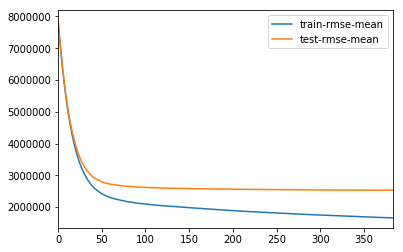

In [19]:
xgb_cvalid = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [20]:
model = xgb.train(params,dtrain,num_boost_round=len(xgb_cvalid))

In [22]:
feature_importance = get_feature_importance(model)
feature_importance.to_csv('Feature_Importance_Base+InFeature.csv',index=False)

In [29]:
feature_importance

,Feature,Score
13,full_sq,1127
209,life_sq,446
16,floor,273
44,build_year,254
121,max_floor,201
191,month_year_cnt,171
105,week_year_cnt,119
182,rel_floor,118
61,kitch_sq,118
141,rel_kitch_sq,117


## Build three feature sets

In [41]:
first_tier_feature = feature_importance[feature_importance['Score']>=80]
print(first_tier_feature.shape)

(16, 2)


In [42]:
second_tier_feature = feature_importance.loc[(feature_importance["Score"] >= 30) & (feature_importance["Score"] <80),]
print(second_tier_feature.shape)

(84, 2)


In [44]:
third_tier_feature = feature_importance[feature_importance['Score']<30]
print(third_tier_feature.shape)

(178, 2)


**First-tier features are divided into three groups based on the following criteria: Need to have a sq_feature, a time feature, a house-state feature and a geographical features in each sub-group. Try to balance the total feature importance in first tier features.**

In [62]:
first_tier_feature

,Feature,Score
13,full_sq,1127
209,life_sq,446
16,floor,273
44,build_year,254
121,max_floor,201
191,month_year_cnt,171
105,week_year_cnt,119
182,rel_floor,118
61,kitch_sq,118
141,rel_kitch_sq,117


In [85]:
first_tier_group1 = ['full_sq','railroad_km','month','room_size']
first_tier_group2 = ['life_sq','week_year_cnt','max_floor','state','kindergarten_km','kitch_sq']
first_tier_group3 = [each for each in first_tier_feature['Feature'] if each not in first_tier_group1+first_tier_group2]

In [86]:
print(sum(first_tier_feature[first_tier_feature['Feature'].isin(first_tier_group1)]['Score']))
print(sum(first_tier_feature[first_tier_feature['Feature'].isin(first_tier_group2)]['Score']))
print(sum(first_tier_feature[first_tier_feature['Feature'].isin(first_tier_group3)]['Score']))

1393
1080
1034


**Second and third features are always telling similar stories. Therefore, we just divide them by making sure the feature importances are balanced.**

In [99]:
Cum_score = []
for i in range(len(second_tier_feature)):
    if i ==0:
        Cum_score.append(list(second_tier_feature['Score'])[i])
    else:
        Cum_score.append(list(second_tier_feature['Score'])[i]+Cum_score[i-1])
Percentile = Cum_score/sum(second_tier_feature['Score'])
second_tier_feature['Percentile'] = Percentile
second_tier_feature = second_tier_feature.reset_index(drop=True)

/home/jiashen/env3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [130]:
second_tier_group1 = list(second_tier_feature['Feature'])[:20]
second_tier_group2 = list(second_tier_feature['Feature'])[20:48]
second_tier_group3 = list(second_tier_feature['Feature'])[48:]

**Same thing for third tier**

In [115]:
Cum_score = []
for i in range(len(third_tier_feature)):
    if i ==0:
        Cum_score.append(list(third_tier_feature['Score'])[i])
    else:
        Cum_score.append(list(third_tier_feature['Score'])[i]+Cum_score[i-1])
Percentile = Cum_score/sum(third_tier_feature['Score'])
third_tier_feature['Percentile'] = Percentile
third_tier_feature = third_tier_feature.reset_index(drop=True)

/home/jiashen/env3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [121]:
third_tier_group1 = list(third_tier_feature['Feature'])[:28]
third_tier_group2 = list(third_tier_feature['Feature'])[28:72]
third_tier_group3 = list(third_tier_feature['Feature'])[72:]

**Put Features Together**

In [131]:
Group1 = first_tier_group1 + second_tier_group1 + third_tier_group1
Group2 = first_tier_group2 + second_tier_group2 + third_tier_group2
Group3 = first_tier_group3 + second_tier_group3 + third_tier_group3

**Now we can start building three models on different groups of features.**

## xgboost on Group 1

In [157]:
train_group1 = train[Group1]
label = train['price_doc']*0.96+10

In [243]:
dtrain1 = xgb.DMatrix(train_group1,label)
dtest1 = xgb.DMatrix(test[Group1])

In [244]:
params_xgb = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 5,## Try 4,5,6
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.92219e+06+47021.3	test-rmse:7.92467e+06+97026.8
[50]	train-rmse:2.5238e+06+29801.5	test-rmse:2.83103e+06+73956.8
[100]	train-rmse:2.20615e+06+25044.3	test-rmse:2.66751e+06+74886.1
[150]	train-rmse:2.10578e+06+22213.6	test-rmse:2.64747e+06+77206.6
[200]	train-rmse:2.02956e+06+15558.8	test-rmse:2.64076e+06+77908.7
[250]	train-rmse:1.96551e+06+14072.6	test-rmse:2.63723e+06+77158.5
[300]	train-rmse:1.90797e+06+10071.2	test-rmse:2.63367e+06+76589.1
Performance does not improve from 307 rounds


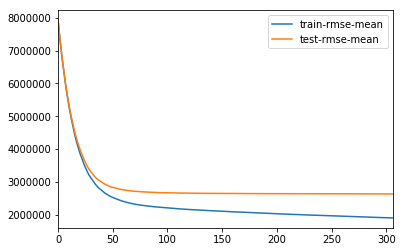

In [160]:
xgb_cvalid = xgb.cv(params_xgb, dtrain1, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [245]:
model1 = xgb.train(params_xgb,dtrain1,num_boost_round=307)

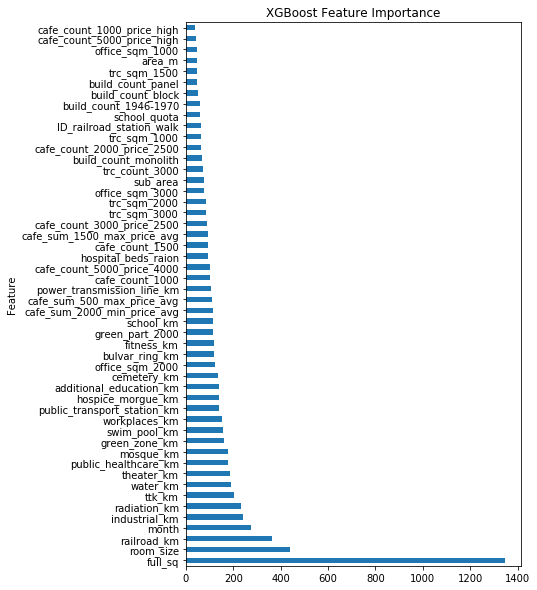

In [162]:
import matplotlib.pyplot as plt
plot_importance(model1)

In [246]:
xgb_feature = model1.predict(dtrain1)
xgb_predict = model1.predict(dtest1)

## Random Forest on Group 2

In [247]:
train_group2 = train[Group2]
label = train['price_doc']*0.96+10
train_group2 = train_group2.fillna(-999)
test_group2 = test[Group2]
test_group2 = test_group2.fillna(-999)

In [177]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE

In [170]:
training = train_group2.iloc[:round(len(train_group2)*0.8),]
testing = train_group2.iloc[round(len(train_group2)*0.8):,]

In [174]:
label_train = label[:round(len(train_group2)*0.8)]
label_test =  label[round(len(train_group2)*0.8):]

In [193]:
reg = RandomForestRegressor(n_estimators= 500,max_features= 'auto',max_depth=8,random_state=42,n_jobs=-1)
reg.fit(training,label_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [194]:
intrain_predict = reg.predict(training)
outtrain_predict = reg.predict(testing)
intrain_RMSE = MSE(intrain_predict,label_train)**0.5
outtrain_RMSE = MSE(outtrain_predict,label_test)**0.5
print('%.2e' %intrain_RMSE)
print('%.2e' %outtrain_RMSE)
#RandomForestRegressor(n_estimators= 1000,max_features=0.7,max_depth=5,random_state=42,n_jobs=-1)
#3.03e+06
#3.74e+06
#RandomForestRegressor(n_estimators= 500,max_features=0.7,max_depth=6,random_state=42,n_jobs=-1)
#2.80e+06
#3.54e+06
#RandomForestRegressor(n_estimators= 1000,max_features=0.7,max_depth=6,random_state=42,n_jobs=-1)
#2.80e+06
#3.55e+06
#RandomForestRegressor(n_estimators= 500,max_features= 'auto',max_depth=6,random_state=42,n_jobs=-1)
#2.79e+06
#3.52e+06
#RandomForestRegressor(n_estimators= 500,max_features= 'auto',max_depth=7,random_state=42,n_jobs=-1)
#2.59e+06
#3.40e+06
#RandomForestRegressor(n_estimators= 500,max_features= 'auto',max_depth=8,random_state=42,n_jobs=-1)
#2.42e+06
#3.33e+06

2.27e+06
3.29e+06


In [248]:
reg = RandomForestRegressor(n_estimators= 500,max_features= 'auto',max_depth=8,random_state=42,n_jobs=-1)
reg.fit(train_group2,label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [249]:
rf_feature = reg.predict(train_group2)
rf_predict = reg.predict(test_group2)

In [199]:
feature_rf = list(train_group2.columns)
feature_imp = list(reg.feature_importances_)

In [202]:
RF_importance = pd.DataFrame({'feature':feature_rf,'Score':feature_imp}).sort_values(by='Score',ascending=[0])

In [203]:
RF_importance

,Score,feature
0,0.350421,life_sq
38,0.114628,cafe_count_3000
5,0.073601,kitch_sq
4,0.038677,kindergarten_km
57,0.027777,cafe_count_3000_price_1500
46,0.026499,cafe_count_1500_price_2500
26,0.025118,zd_vokzaly_avto_km
17,0.019900,nuclear_reactor_km
15,0.016961,university_km
3,0.015584,state


## Gradient Boosting on Group 3

In [250]:
train_group3 = train[Group3]
label = train['price_doc']*0.96+10
train_group3 = train_group3.replace([np.inf, -np.inf], np.nan)
train_group3 = train_group3.fillna(-999)
test_group3 = test[Group3]
test_group3 = test_group3.replace([np.inf, -np.inf], np.nan)
test_group3 = test_group3.fillna(-999)

In [211]:
from sklearn.ensemble import GradientBoostingRegressor

In [217]:
label_train = label[:round(len(train_group3)*0.8)]
label_test =  label[round(len(train_group3)*0.8):]

In [218]:
training = train_group3.iloc[:round(len(train_group3)*0.8),]
testing = train_group3.iloc[round(len(train_group3)*0.8):,]

In [225]:
reg = GradientBoostingRegressor(learning_rate=0.05,n_estimators=800,max_depth=6,max_features = 'auto',subsample = 1)
reg.fit(training,label_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=6,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=None,
             subsample=1, verbose=0, warm_start=False)

In [226]:
intrain_predict = reg.predict(training)
outtrain_predict = reg.predict(testing)
intrain_RMSE = MSE(intrain_predict,label_train)**0.5
outtrain_RMSE = MSE(outtrain_predict,label_test)**0.5
print('%.2e' %intrain_RMSE)
print('%.2e' %outtrain_RMSE)
#GradientBoostingRegressor(learning_rate=0.05,n_estimators=500,max_depth=5,max_features = 'auto',subsample = 1)
#2.13e+06
#3.11e+06
#GradientBoostingRegressor(learning_rate=0.05,n_estimators=500,max_depth=6,max_features = 'auto',subsample = 1)
#1.89e+06
#3.08e+06
#GradientBoostingRegressor(learning_rate=0.1,n_estimators=500,max_depth=6,max_features = 'auto',subsample = 1)
#1.49e+06
#3.15e+06
#GradientBoostingRegressor(learning_rate=0.05,n_estimators=800,max_depth=6,max_features = 'auto',subsample = 1)
#1.65e+06
#3.07e+06

1.65e+06
3.07e+06


In [227]:
reg = GradientBoostingRegressor(learning_rate=0.05,n_estimators=800,max_depth=6,max_features = 'auto',subsample = 1)

In [251]:
reg.fit(train_group3,label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [252]:
GBM_feature = reg.predict(train_group3)
GBM_predict = reg.predict(test_group3)

In [230]:
feature_GBM = list(train_group3.columns)
feature_imp = list(reg.feature_importances_)

In [231]:
GBM_importance = pd.DataFrame({'feature':feature_GBM,'Score':feature_imp}).sort_values(by='Score',ascending=[0])

In [232]:
GBM_importance

,Score,feature
2,0.053180,month_year_cnt
0,0.047496,floor
4,0.040120,rel_kitch_sq
1,0.035038,build_year
5,0.034652,num_room
32,0.028240,big_market_km
18,0.026197,shopping_centers_km
3,0.024184,rel_floor
31,0.022056,apartment_name
16,0.020171,green_part_500


## Stack results of three models by XGBoost

In [253]:
stack_features = pd.DataFrame({'Group1':xgb_feature,'Group2':rf_feature,'Group3':GBM_feature})
stact_predict = pd.DataFrame({'Group1':xgb_predict,'Group2':rf_predict,'Group3':GBM_predict})

In [254]:
dtrain_stack = xgb.DMatrix(stack_features,label)
dtest_stack = xgb.DMatrix(stact_predict)

In [240]:
params_stack = {
    'eta': 0.05, ## Try 0.01,3,5
    'max_depth': 3,## Try 4,5,6
    'subsample': 0.5,
    'colsample_bytree': 1,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

[0]	train-rmse:7.84736e+06+46000.6	test-rmse:7.8468e+06+90864.5
[50]	train-rmse:1.72347e+06+15146.4	test-rmse:1.75164e+06+30959
[100]	train-rmse:1.55367e+06+11122.2	test-rmse:1.59721e+06+21755.8
[150]	train-rmse:1.53093e+06+9486.06	test-rmse:1.58583e+06+21195.5
[200]	train-rmse:1.51691e+06+9412.05	test-rmse:1.58043e+06+18921.1
[250]	train-rmse:1.50511e+06+8623.31	test-rmse:1.57693e+06+17954.3
[300]	train-rmse:1.49418e+06+8230.59	test-rmse:1.57391e+06+17534.6
[350]	train-rmse:1.48448e+06+7853.24	test-rmse:1.57273e+06+17070.3
[400]	train-rmse:1.47551e+06+7594.6	test-rmse:1.5711e+06+16486.9
Performance does not improve from 402 rounds


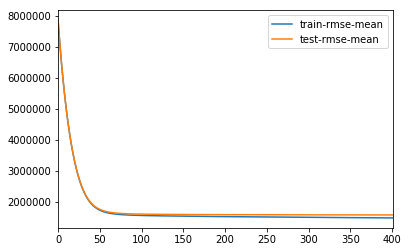

In [241]:
xgb_cvalid = xgb.cv(params_stack, dtrain_stack, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=True,seed=42)
xgb_cvalid[['train-rmse-mean', 'test-rmse-mean']].plot()
print('Performance does not improve from '+str(len(xgb_cvalid))+' rounds')

In [242]:
stack_model = xgb.train(params_stack,dtrain_stack,num_boost_round=len(xgb_cvalid))

In [255]:
Final_pred = stack_model.predict(dtest_stack)

In [306]:
Final_pred_mult =Final_pred*0.9734

In [307]:
Final_pred_mult

array([ 5259320.5,  8067346.5,  5691758.5, ...,  5128262. ,  5068479.5,
        8054352.5], dtype=float32)

## Check it with LB66 Prediction

In [ ]:
LB66 = pd.read_csv('sub.csv')['price_doc']

In [308]:
def mean_error(line1,line2):
    error = [x-y for x,y in zip(line1,line2)]
    return np.mean(error)

In [312]:
def Count_less_values(line1,line2):
    lst = [1 if x<y else 0 for x,y in zip(line1,line2)]
    return sum(lst)/len(test)

In [309]:
mean_error(list(Final_pred_mult),LB66)

-167.00427434090315

In [313]:
Count_less_values(list(Final_pred_mult),LB66)

0.5

In [314]:
sub = pd.DataFrame({'id':test['id'],'price_doc':Final_pred_mult})
sub.to_csv('StackingRFXGBGBM.csv',index=False)

In [258]:
LB66 = pd.read_csv('sub.csv')['price_doc']